In [ ]:
import tensorflow as tf

a=tf.random_normal((10,10))
b=tf.random_normal((10,50))
c=tf.matmul(a,b)
sess=tf.InteractiveSession()
print(sess.run(c))

In [3]:
#MNIST训练示例
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 定义MNIST数据集相关的常数
INPUT_NODE = 784 # 每一张图片都是28*28的
OUTPUT_NODE = 10 # 输出是一个10分类

LAYER1_NODE = 500 # 隐藏层节点数
BATCH_SIZE = 100 # 每个Batch的大小

LEARNING_RATE_BASE = 0.8 # 最开始的学习率
LEARNING_RATE_DECAY = 0.99 # 在指数衰减学习率的过程中用到
REGULARIZATION_RATE = 0.0001 # 描述模型复杂度的正则化项在损失函数中的系数
TRAINING_STEPS = 30000 # 训练轮数，注意，训练一个Batch就是一个step
MOVING_AVERAGE_DECAY = 0.99 # 滑动平均模型的衰减率，最后我会讲解滑动平均模型

# 一个辅助函数，给定神经网络的输入和所有参数，计算神经网络的前向传播结果。在这里
# 定义了一个使用ReLU激活函数的三层全连接神经网络。通过加入隐藏层实现了多层网络结构
# 通过ReLU激活函数实现了去线性化。在这个函数中也支持传入用于计算参数平均值的类，
# 这样方便在测试时使用滑动平均模型。
def inference(input_tensor, avg_class, weights1, biases1,
               weights2, biases2):
    # 当没有提供滑动平均类时，直接使用参数当前的取值
    if avg_class == None:
        # 计算隐藏层的前向传播结果，这里使用了ReLU激活函数。
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
        # 计算输出层的前向传播结果。因为在计算损失函数时会一并计算softmax函数，
        # 所以这里不需要加入激活函数。而且不加入softmax不会影响预测结果。因为预测时
        # 使用的是不同类别对应节点输出值的相对大小，有没有softmax层对最后分类结果的
        # 计算没有影响。于是在计算整个神经网络的前向传播时可以不加入最后的softmax层。
        return tf.matmul(layer1, weights2) + biases2
    else:
        # 首先使用avg_class.average函数来计算得出变量的滑动平均值，
        # 然后再计算相应的神经网络前向传播结果。
        layer1 = tf.nn.relu(
            tf.matmul(input_tensor, avg_class.average(weights1)) +
            avg_class.average(biases1)
        )
        return tf.matmul(layer1, avg_class.average(weights2)) + \
                avg_class.average(biases2)

# 训练模型的过程
# 写TensorFlow程序的时候一定要注意逻辑结构，一般都是下面这个结构：
# 1. 搭建模型：数据输入、数据label、权值初始化、前向传播、反向传播、更新参数
# 2. 运行模型：上面虽然把模型已经搭建好了，但是模型没有真正运行起来
def train(mnist):
    # 模型的输入
    x = tf.placeholder(tf.float32, [None, INPUT_NODE], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-input')
    # 生成隐藏层的参数
    weights1 = tf.Variable(
        tf.truncated_normal([INPUT_NODE, LAYER1_NODE], stddev=0.1)
    )
    biases1 = tf.Variable(
        tf.constant(0.1, shape=[LAYER1_NODE])
    )
    # 生成输出层的参数
    weights2 = tf.Variable(
        tf.truncated_normal([LAYER1_NODE, OUTPUT_NODE], stddev=0.1)
    )
    biases2 = tf.Variable(
        tf.constant(0.1, shape=[OUTPUT_NODE])
    )
    # 注意这里：计算在当前参数下神经网络前向传播的结果。这里给出的用于计算滑动平均的类为None，
    # 所以函数不会使用参数的滑动平均值。
    y = inference(x, None, weights1, biases1, weights2, biases2)

    # 定义存储训练轮数的变量。这个变量不需要计算滑动平均值，所以这里指定这个变量为
    # 不可训练的变量(trainable=False)。在使用TensorFlow训练神经网络时，
    # 一般会将代表训练轮数的变量指定为不可训练的参数。
    # 为什么要把它设为0，参见学习率指数衰减的公式，最开始的指数我们让它为0
    # 而且在训练过程中，每一次train_step，global_step都会增加1，所以后面这个值会越来越大
    global_step = tf.Variable(0, trainable=False)

    # 给定滑动平均衰减率和训练轮数的变量，初始化滑动平均类。在第4章中介绍过给
    # 定训练轮数的变量可以加快训练早期变量的更新速度。
    variable_averages = tf.train.ExponentialMovingAverage(
        MOVING_AVERAGE_DECAY, global_step
    )

    # 在所有代表神经网络参数的变量上使用滑动平均。其他辅助变量(比如global_step)就
    # 不需要了。tf.trainable_variable返回的就是图上集合
    # GraphKeys.TRAINABLE_VARIABLES中的元素。这个集合的元素就是所有没有指定
    # trainable=False的参数。
    variable_averages_op = variable_averages.apply(
        tf.trainable_variables()
    )

    # 注意这个与上面的y有什么区别。计算使用了滑动平均之后的前向传播结果。第4章中介绍过滑动平均不会改变
    # 变量本身的取值，而是会维护一个影子变量来记录其滑动平均值。所以当需要使用这个滑动平均值时，
    # 需要明确调用average函数。
    average_y = inference(
        x, variable_averages, weights1, biases1, weights2, biases2
    )

    # 计算交叉熵作为刻画预测值和真实值之间差距的损失函数。这里使用了TensorFlow中提
    # 供的sparse_softmax_cross_entropy_with_logits函数来计算交叉熵。当分类
    # 问题只有一个正确答案时，可以使用这个函数来加速交叉熵的计算。MNIST问题的图片中
    # 只包含了0~9中的一个数字，所以可以使用这个函数来计算交叉熵损失。这个函数的第一个
    # 参数是神经网络不包括softmax层的前向传播结果，第二个是训练数据的正确答案。因为
    # 标准答案是一个长度位10的一维数组，而该函数需要提供的是一个正确答案的数字，所以需
    # 要使用tf.argmax函数来得到正确答案对应的类别编号。
    # 注意这里用的是y来计算交叉熵而不是average_y
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=y, labels=tf.argmax(y_, 1)
    )
    # 计算在当前batch中所有样例的交叉熵平均值
    cross_entropy_mean = tf.reduce_mean(cross_entropy)

    # 计算L2正则化损失函数
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    # 计算模型的正则化损失。一般只计算神经网络边上权重的正则化损失，而不使用偏置项。
    regularization = regularizer(weights1) + regularizer(weights2)
    # 总损失等于交叉熵损失和正则化损失的和
    loss = cross_entropy_mean + regularization
    # 设置指数衰减的学习率
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE, # 基础的学习率，随着迭代的进行，更新变量时使用的
                            # 学习率在这个基础上递减
        global_step,        # 当前迭代的轮数
        mnist.train.num_examples / BATCH_SIZE, # 过完所有的训练数据需要的迭代次数
        LEARNING_RATE_DECAY # 学习率的衰减速度
    )
    # 使用tf.train.GradientDescentOptimizer优化算法来优化损失函数。注意这里损失函数
    # 包含了交叉熵损失和L2正则化损失。
    # 在这个函数中，每次执行global_step都会加一。注意这个函数优化的损失函数跟y有关，
    # 跟average_y无关。
    train_step = tf.train.GradientDescentOptimizer(learning_rate)\
                 .minimize(loss, global_step=global_step)

    # 在训练神经网络模型时，每过一遍数据既需要通过反向传播来更新神经网络中的参数，
    # 又要更新每个参数的滑动平均值。为了一次完成多个操作，TensorFlow提供了
    # tf.control_dependencies和tf.group两种机制。下面两行程序和
    # train_op = tf.group(train_step, variables_average_op)是等价的。
    with tf.control_dependencies([train_step, variable_averages_op]):
        train_op = tf.no_op(name='train') # tf.no_op是一个没有实际意义的函数

    # 检验使用了滑动平均模型的神经网络前向传播结果是否正确。tf.argmax(average_y, 1)
    # 计算每一个样例的预测结果。其中average_y是一个batch_size * 10的二维数组，每一行
    # 表示一个样例的前向传播结果。tf.argmax的第二个参数“1”表示选取最大值的操作仅在第一
    # 个维度中进行，也就是说，只在每一行选取最大值对应的下标。于是得到的结果是一个长度为
    # batch的一维数组，这个一维数组中的值就表示了每一个样例对应的数字识别结果。tf.equal
    # 判断两个张量的每一维是否相等，如果相等返回True，否则返回False。
    correct_prediction = tf.equal(tf.argmax(average_y, 1), tf.argmax(y_, 1))
    # 注意这个accuracy是只跟average_y有关的，跟y是无关的
    # 这个运算首先讲一个布尔型的数值转化为实数型，然后计算平均值。这个平均值就是模型在这
    # 一组数据上的正确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # 前面的所有步骤都是在构建模型，将一个完整的计算图补充完了，现在开始运行模型
    # 初始化会话并且开始训练过程
    with tf.Session() as sess:
        # 初始化变量
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        # 准备验证数据。一般在神经网络的训练过程中会通过验证数据要大致判断停止的
        # 条件和评判训练的效果。
        validate_feed = {
            x: mnist.validation.images,
            y_: mnist.validation.labels
        }
        # 准备测试数据。在真实的应用中，这部分数据在训练时是不可见的，这个数据只是作为
        # 模型优劣的最后评价标准。
        test_feed = {
            x: mnist.test.images,
            y_: mnist.test.labels
        }
        # 认真体会这个过程，整个模型的执行流程与逻辑都在这一段
        # 迭代的训练神经网络
        for i in range(TRAINING_STEPS):
            # 每1000轮输出一次在验证数据集上的测试结果
            if i % 1000 == 0:
                # 计算滑动平均模型在验证数据上的结果。因为MNIST数据集比较小，所以一次
                # 可以处理所有的验证数据。为了计算方便，本样例程序没有将验证数据划分为更
                # 小的batch。当神经网络模型比较复杂或者验证数据比较大时，太大的batch
                # 会导致计算时间过长甚至发生内存溢出的错误。
                # 注意我们用的是滑动平均之后的模型来跑我们验证集的accuracy
                validate_acc = sess.run(accuracy, feed_dict=validate_feed)
                print("After %d training step(s), validation accuracy "
                      "using average model is %g " % (i, validate_acc))

            # 产生这一轮使用的一个batch的训练数据，并运行训练过程。
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            sess.run(train_op, feed_dict={x: xs, y_: ys})

        # 在训练结束之后，在测试数据上检测神经网络模型的最终正确率。
        # 同样，我们最终的模型用的是滑动平均之后的模型，从这个accuracy函数
        # 的调用就可以看出来了，因为accuracy只与average_y有关
        test_acc = sess.run(accuracy, feed_dict=test_feed)
        print("After %d training step(s), test accuracy using average "
              "model is %g" % (TRAINING_STEPS, test_acc))

# 主程序入口
def main(argv=None):
    # 声明处理MNIST数据集的类，这个类在初始化时会自动下载数据。
    mnist = input_data.read_data_sets("./data", one_hot=True)
    train(mnist)

# TensorFlow提供的一个主程序入口，tf.app.run会调用上面定义的main函数
if __name__ == "__main__":
    tf.app.run()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/mo

SystemExit: 

D:\Program Files\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3299: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
##Python实现PCA
import numpy as np
def pca(X,k):#k is the components you want
  #mean of each feature
  n_samples, n_features = X.shape
  mean=np.array([np.mean(X[:,i]) for i in range(n_features)])
  #normalization中心化
  norm_X=X-mean
  #scatter matrix
  scatter_matrix=np.dot(np.transpose(norm_X),norm_X)
  #Calculate the eigenvectors and eigenvalues
  eig_val, eig_vec = np.linalg.eig(scatter_matrix)
  eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(n_features)]
  # sort eig_vec based on eig_val from highest to lowest
  eig_pairs.sort(reverse=True)
  # select the top k eig_vec
  feature=np.array([ele[1] for ele in eig_pairs[:k]])
  #get new data
  data=np.dot(norm_X,np.transpose(feature))
  return data
 
X = np.array([[-1, 1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
print(pca(X,1))

[[-0.50917706]
 [-2.40151069]
 [-3.7751606 ]
 [ 1.20075534]
 [ 2.05572155]
 [ 3.42937146]]


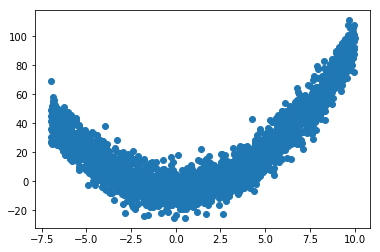

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


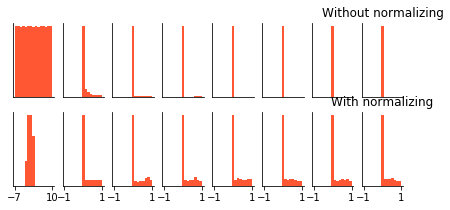

D:\Program Files\Python\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Program Files\Python\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


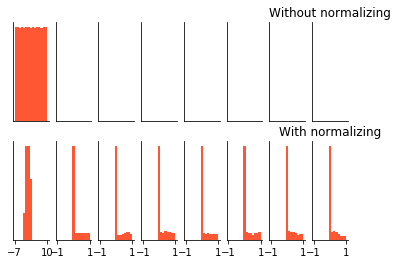

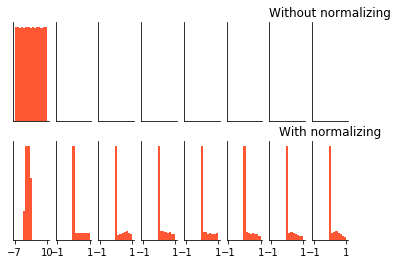

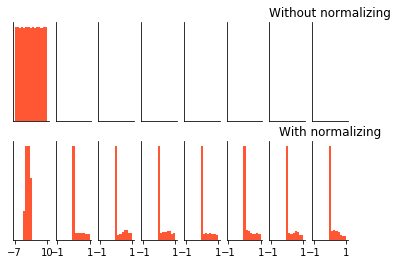

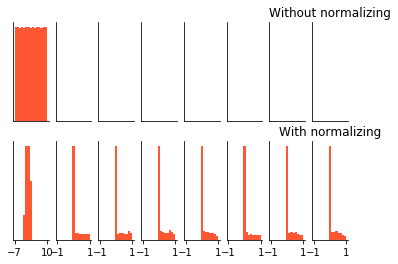

In [8]:
"""
visit https://morvanzhou.github.io/tutorials/ for more!
Build two networks.
1. Without batch normalization
2. With batch normalization
Run tests on these two networks.
"""

# 23 Batch Normalization

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


ACTIVATION = tf.nn.relu
N_LAYERS = 7
N_HIDDEN_UNITS = 30


def fix_seed(seed=1):
    # reproducible
    np.random.seed(seed)
    tf.set_random_seed(seed)


def plot_his(inputs, inputs_norm):
    # plot histogram for the inputs of every layer
    for j, all_inputs in enumerate([inputs, inputs_norm]):
        for i, input in enumerate(all_inputs):
            plt.subplot(2, len(all_inputs), j*len(all_inputs)+(i+1))
            plt.cla()
            if i == 0:
                the_range = (-7, 10)
            else:
                the_range = (-1, 1)
            plt.hist(input.ravel(), bins=15, range=the_range, color='#FF5733')
            plt.yticks(())
            if j == 1:
                plt.xticks(the_range)
            else:
                plt.xticks(())
            ax = plt.gca()
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
        plt.title("%s normalizing" % ("Without" if j == 0 else "With"))
    plt.draw()
    plt.pause(0.01)


def built_net(xs, ys, norm):
    def add_layer(inputs, in_size, out_size, activation_function=None, norm=False):
        # weights and biases (bad initialization for this case)
        Weights = tf.Variable(tf.random_normal([in_size, out_size], mean=0., stddev=1.))
        biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)

        # fully connected product
        Wx_plus_b = tf.matmul(inputs, Weights) + biases

        # normalize fully connected product
        if norm:
            # Batch Normalize
            fc_mean, fc_var = tf.nn.moments(
                Wx_plus_b,
                axes=[0],   # the dimension you wanna normalize, here [0] for batch
                            # for image, you wanna do [0, 1, 2] for [batch, height, width] but not channel
            )
            scale = tf.Variable(tf.ones([out_size]))
            shift = tf.Variable(tf.zeros([out_size]))
            epsilon = 0.001

            # apply moving average for mean and var when train on batch
            ema = tf.train.ExponentialMovingAverage(decay=0.5)
            def mean_var_with_update():
                ema_apply_op = ema.apply([fc_mean, fc_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)
            mean, var = mean_var_with_update()

            Wx_plus_b = tf.nn.batch_normalization(Wx_plus_b, mean, var, shift, scale, epsilon)
            # similar with this two steps:
            # Wx_plus_b = (Wx_plus_b - fc_mean) / tf.sqrt(fc_var + 0.001)
            # Wx_plus_b = Wx_plus_b * scale + shift

        # activation
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)

        return outputs

    fix_seed(1)

    if norm:
        # BN for the first input
        fc_mean, fc_var = tf.nn.moments(
            xs,
            axes=[0],
        )
        scale = tf.Variable(tf.ones([1]))
        shift = tf.Variable(tf.zeros([1]))
        epsilon = 0.001
        # apply moving average for mean and var when train on batch
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        def mean_var_with_update():
            ema_apply_op = ema.apply([fc_mean, fc_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(fc_mean), tf.identity(fc_var)
        mean, var = mean_var_with_update()
        xs = tf.nn.batch_normalization(xs, mean, var, shift, scale, epsilon)

    # record inputs for every layer
    layers_inputs = [xs]

    # build hidden layers
    for l_n in range(N_LAYERS):
        layer_input = layers_inputs[l_n]
        in_size = layers_inputs[l_n].get_shape()[1].value

        output = add_layer(
            layer_input,    # input
            in_size,        # input size
            N_HIDDEN_UNITS, # output size
            ACTIVATION,     # activation function
            norm,           # normalize before activation
        )
        layers_inputs.append(output)    # add output for next run

    # build output layer
    prediction = add_layer(layers_inputs[-1], 30, 1, activation_function=None)

    cost = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction), reduction_indices=[1]))
    train_op = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
    return [train_op, cost, layers_inputs]

# make up data
fix_seed(1)
x_data = np.linspace(-7, 10, 2500)[:, np.newaxis]
np.random.shuffle(x_data)
noise = np.random.normal(0, 8, x_data.shape)
y_data = np.square(x_data) - 5 + noise

# plot input data
plt.scatter(x_data, y_data)
plt.show()

xs = tf.placeholder(tf.float32, [None, 1])  # [num_samples, num_features]
ys = tf.placeholder(tf.float32, [None, 1])

train_op, cost, layers_inputs = built_net(xs, ys, norm=False)   # without BN
train_op_norm, cost_norm, layers_inputs_norm = built_net(xs, ys, norm=True) # with BN

sess = tf.Session()
if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
    init = tf.initialize_all_variables()
else:
    init = tf.global_variables_initializer()
sess.run(init)

# record cost
cost_his = []
cost_his_norm = []
record_step = 5

plt.ion()
plt.figure(figsize=(7, 3))
for i in range(250):
    if i % 50 == 0:
        # plot histogram
        all_inputs, all_inputs_norm = sess.run([layers_inputs, layers_inputs_norm], feed_dict={xs: x_data, ys: y_data})
        plot_his(all_inputs, all_inputs_norm)

    # train on batch
    sess.run([train_op, train_op_norm], feed_dict={xs: x_data[i*10:i*10+10], ys: y_data[i*10:i*10+10]})

    if i % record_step == 0:
        # record cost
        cost_his.append(sess.run(cost, feed_dict={xs: x_data, ys: y_data}))
        cost_his_norm.append(sess.run(cost_norm, feed_dict={xs: x_data, ys: y_data}))

plt.ioff()
plt.figure()
plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his), label='no BN')     # no norm
plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his_norm), label='BN')   # norm
plt.legend()
plt.show()


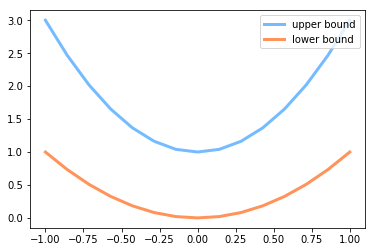

Instructions for updating:
Use keras.layers.dense instead.


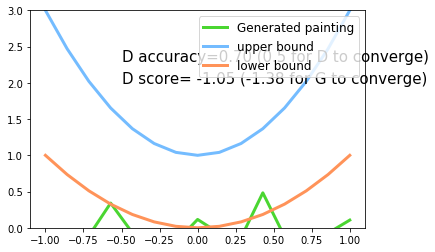

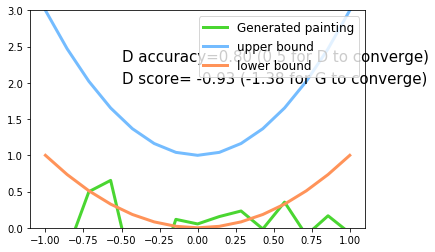

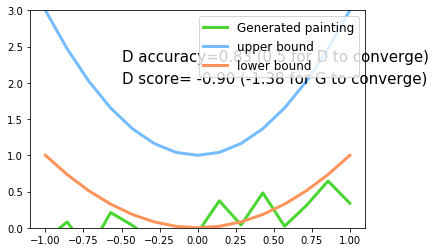

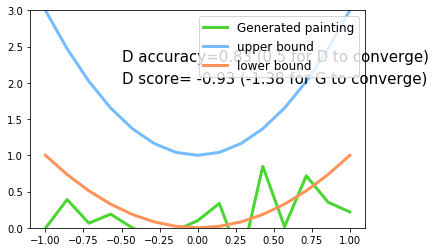

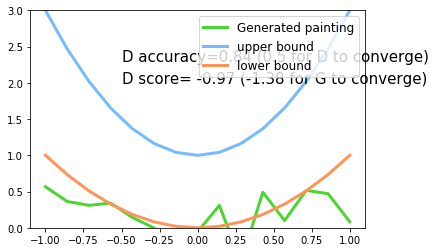

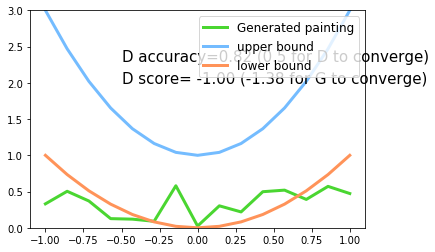

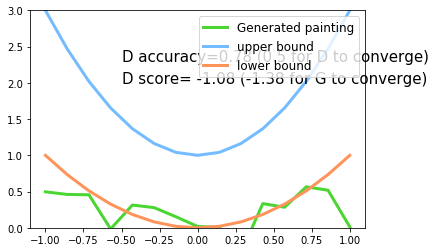

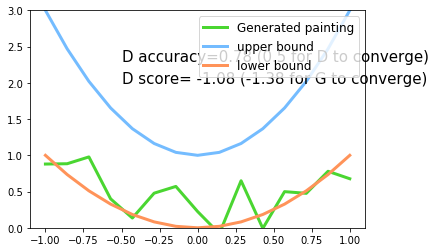

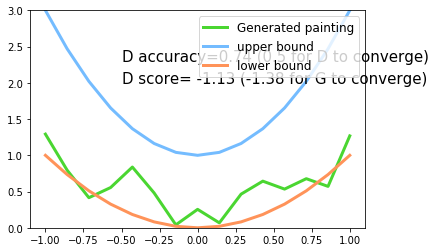

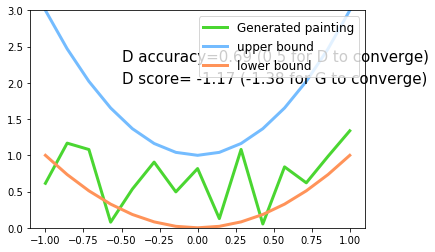

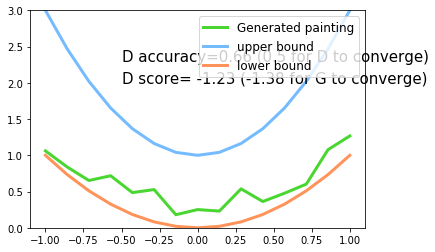

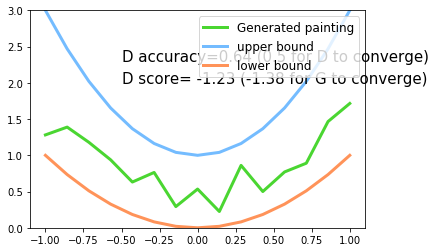

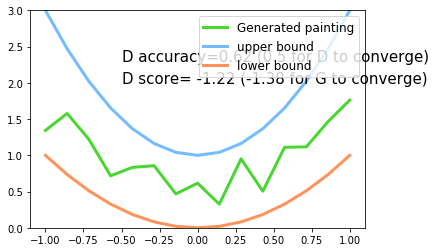

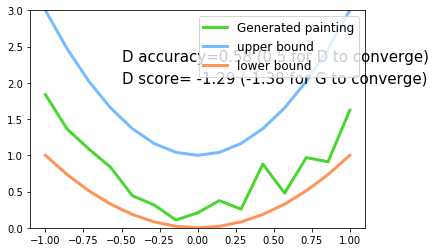

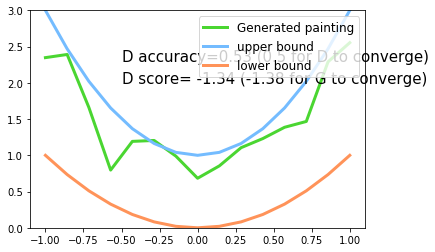

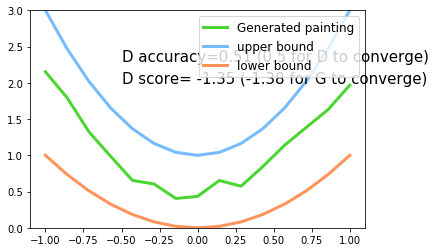

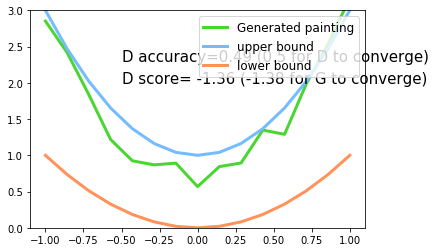

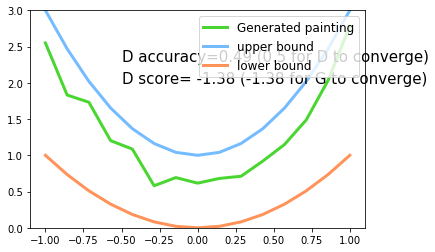

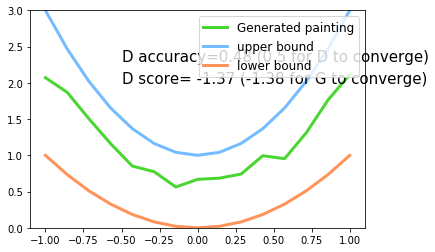

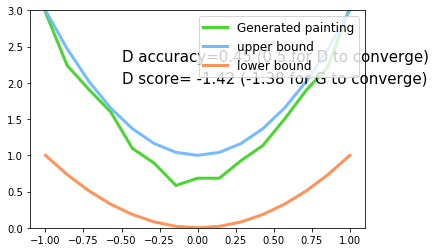

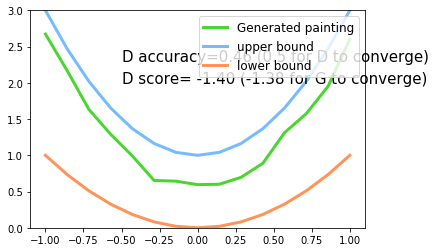

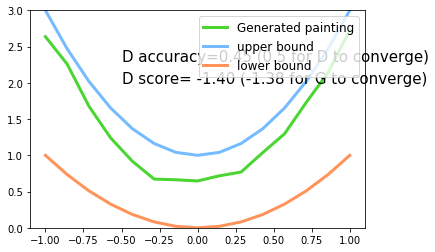

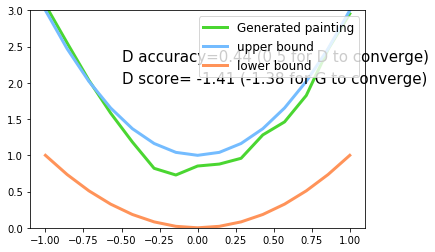

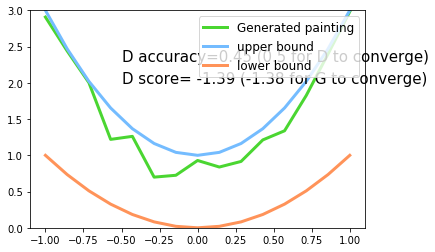

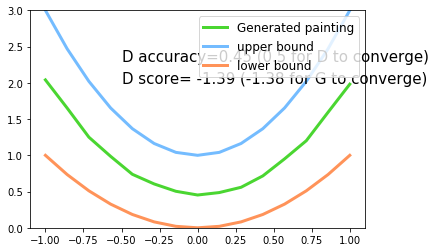

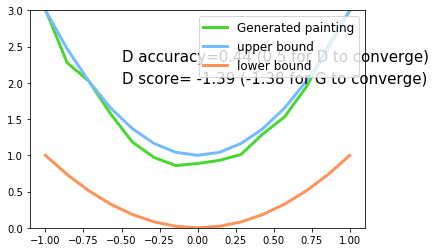

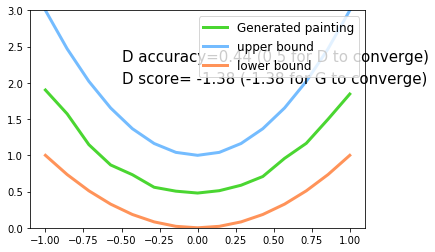

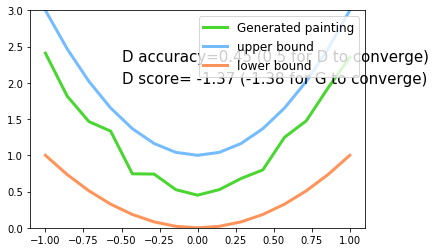

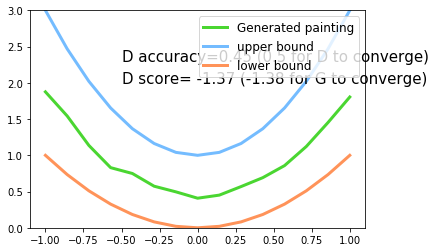

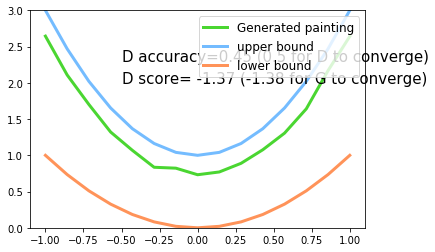

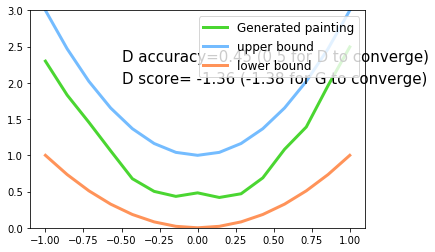

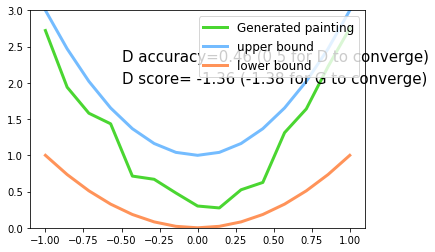

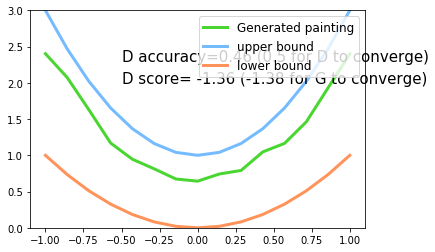

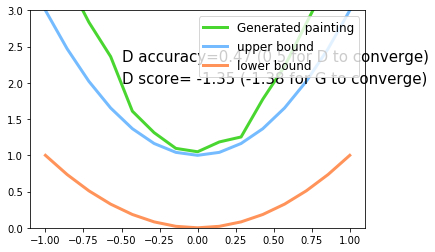

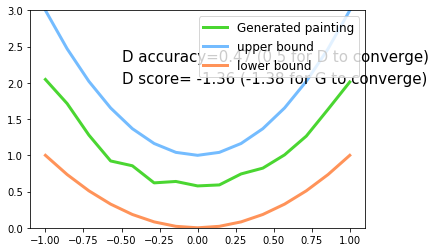

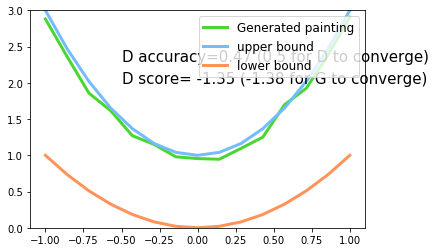

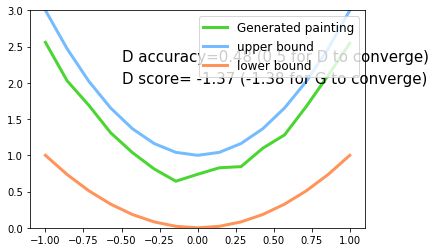

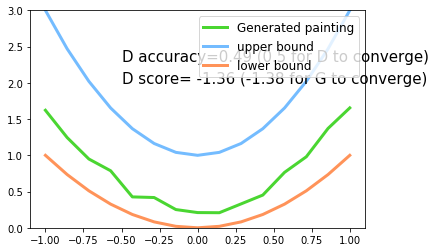

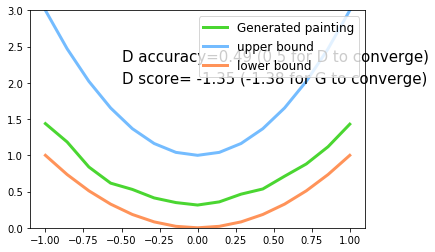

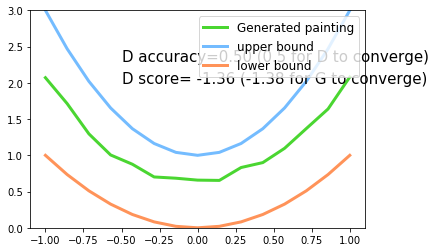

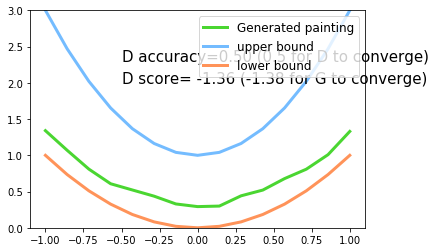

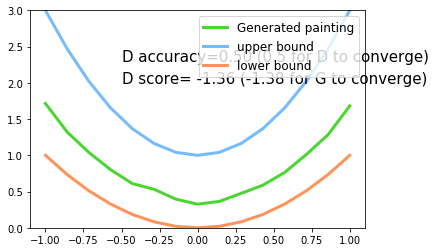

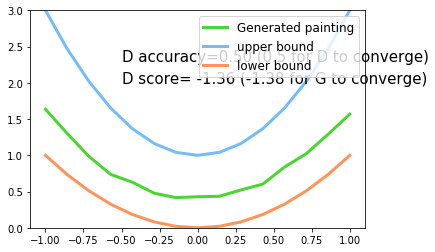

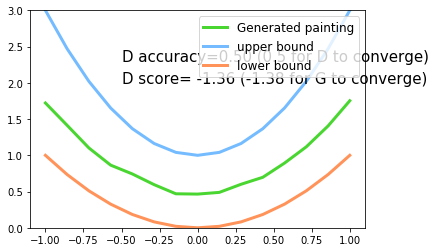

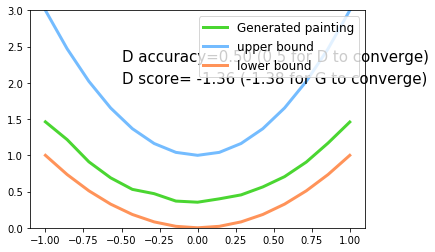

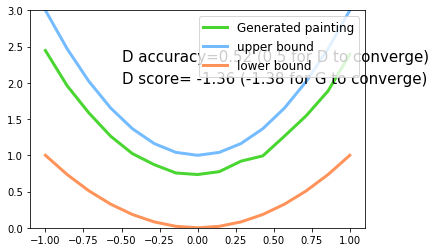

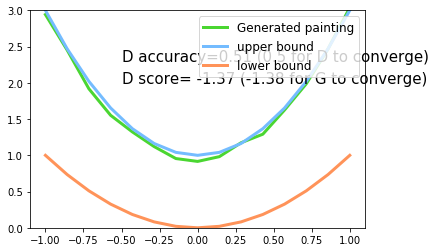

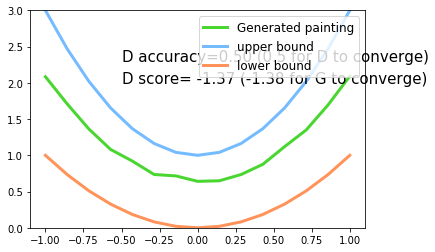

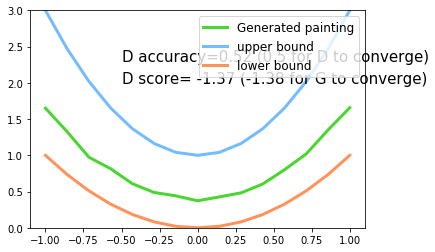

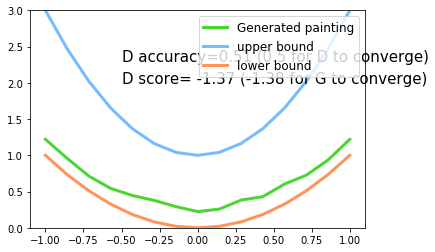

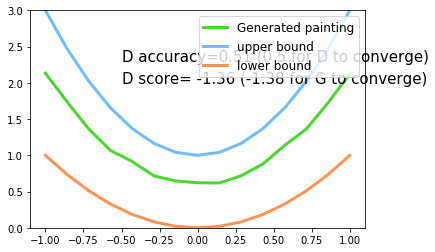

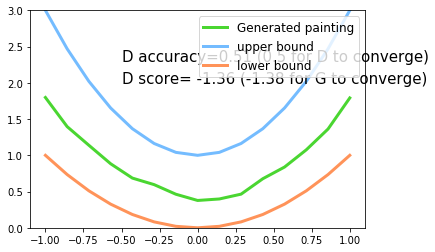

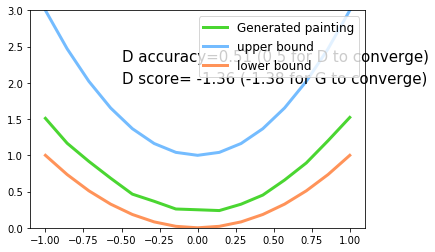

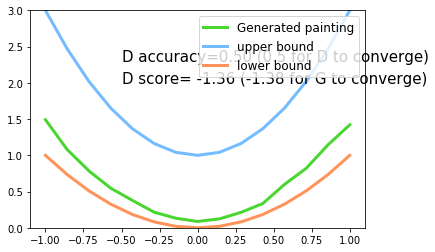

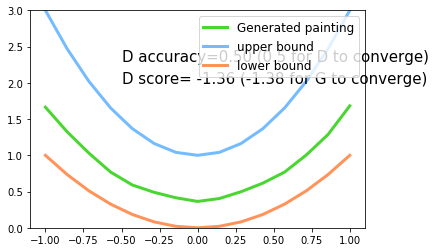

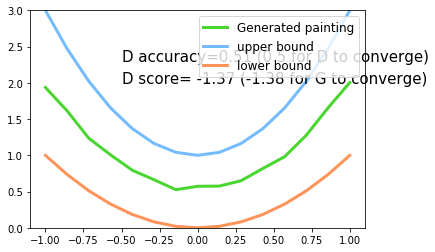

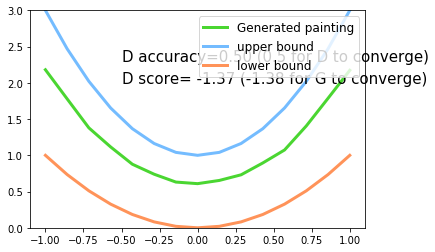

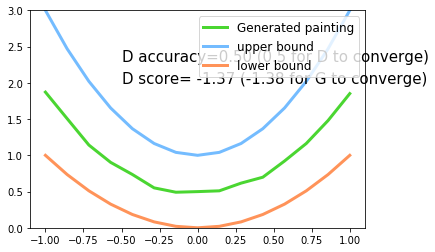

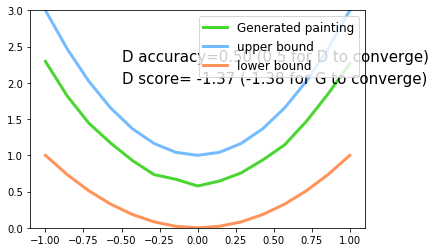

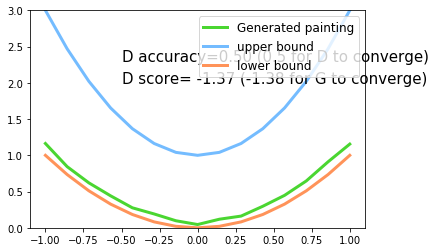

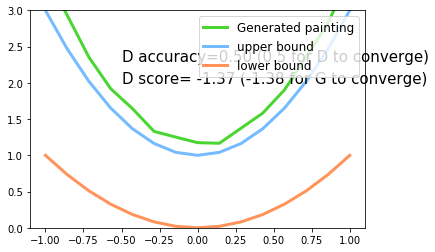

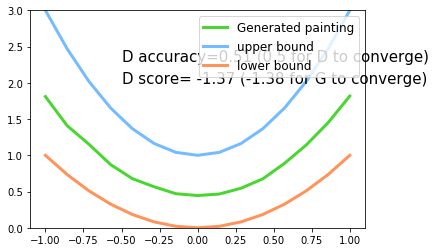

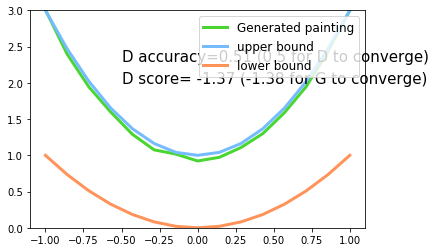

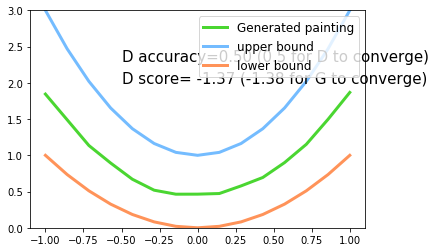

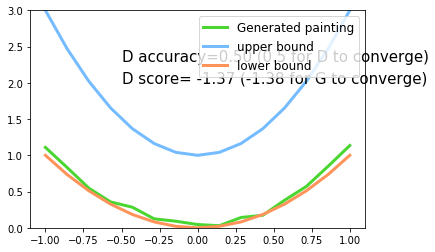

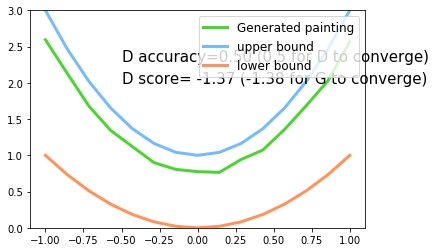

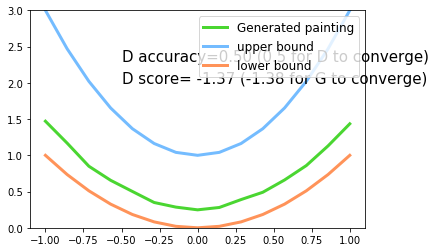

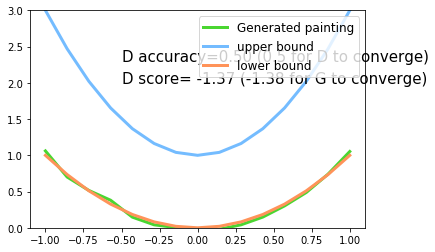

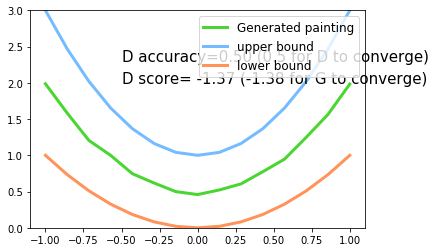

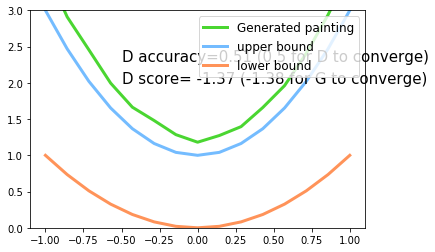

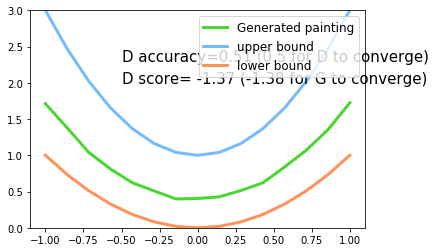

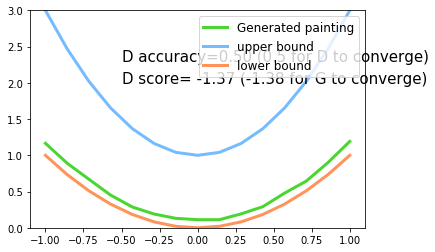

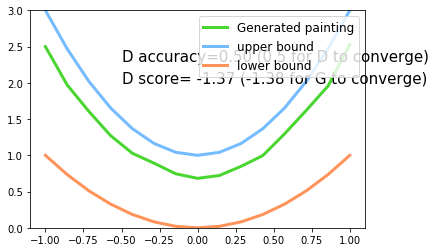

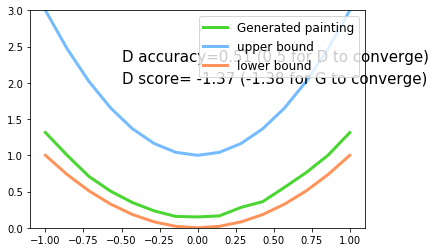

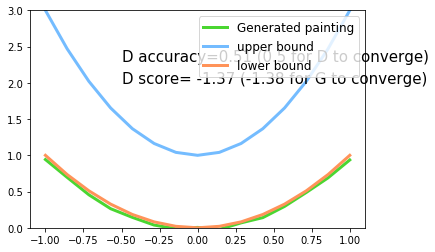

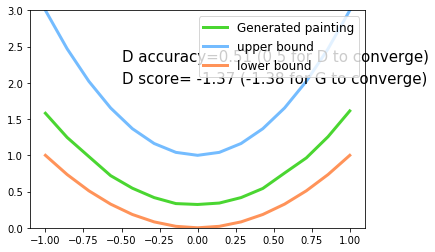

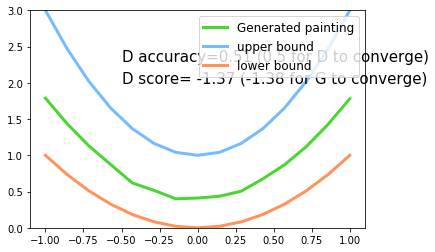

In [9]:
"""
Know more, visit my Python tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
tensorflow: 1.1.0
matplotlib
numpy
"""
# Gan Test
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()


def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    return paintings


with tf.variable_scope('Generator'):
    G_in = tf.placeholder(tf.float32, [None, N_IDEAS])          # random ideas (could from normal distribution)
    G_l1 = tf.layers.dense(G_in, 128, tf.nn.relu)
    G_out = tf.layers.dense(G_l1, ART_COMPONENTS)               # making a painting from these random ideas

with tf.variable_scope('Discriminator'):
    real_art = tf.placeholder(tf.float32, [None, ART_COMPONENTS], name='real_in')   # receive art work from the famous artist
    D_l0 = tf.layers.dense(real_art, 128, tf.nn.relu, name='l')
    prob_artist0 = tf.layers.dense(D_l0, 1, tf.nn.sigmoid, name='out')              # probability that the art work is made by artist
    # reuse layers for generator
    D_l1 = tf.layers.dense(G_out, 128, tf.nn.relu, name='l', reuse=True)            # receive art work from a newbie like G
    prob_artist1 = tf.layers.dense(D_l1, 1, tf.nn.sigmoid, name='out', reuse=True)  # probability that the art work is made by artist

D_loss = -tf.reduce_mean(tf.log(prob_artist0) + tf.log(1-prob_artist1))
G_loss = tf.reduce_mean(tf.log(1-prob_artist1))

train_D = tf.train.AdamOptimizer(LR_D).minimize(
    D_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator'))
train_G = tf.train.AdamOptimizer(LR_G).minimize(
    G_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator'))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

plt.ion()   # something about continuous plotting
for step in range(5000):
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = np.random.randn(BATCH_SIZE, N_IDEAS)
    G_paintings, pa0, Dl = sess.run([G_out, prob_artist0, D_loss, train_D, train_G],    # train and get results
                                    {G_in: G_ideas, real_art: artist_paintings})[:3]

    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % pa0.mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -Dl, fontdict={'size': 15})
        plt.ylim((0, 3)); plt.legend(loc='upper right', fontsize=12); plt.draw(); plt.pause(0.01)

plt.ioff()
plt.show()